## Imports

In [65]:
import numpy as np
import imageio
import cv2
import json
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

## Seeding

Assumes pre-defined mask listed in mask_notebook. Can be updated directly on the file 

## Main Program

Loads image

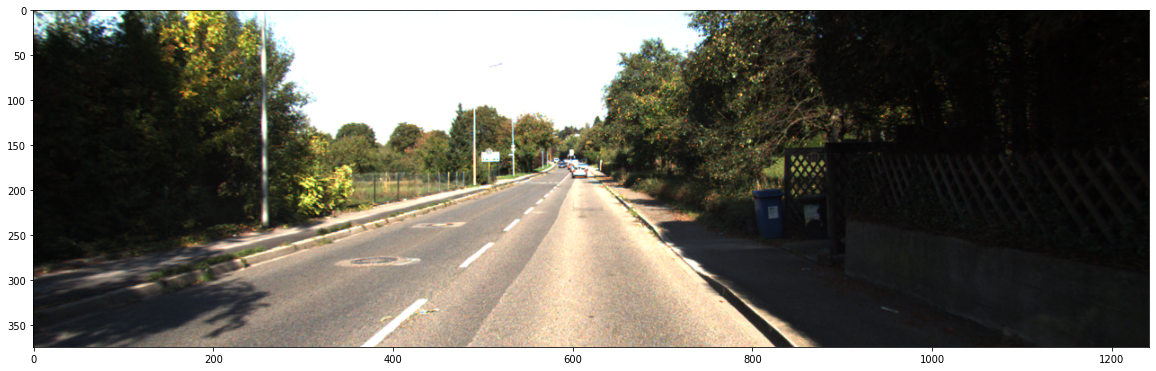

In [20]:
# Load image
image_path = "dataset_examples/um_000052.png"
image = imageio.imread(image_path)
plt.figure(figsize=(15, 15))
plt.imshow(image)

## Image Pre-processing

Applies a series of transformations to input image in order to 

In [52]:
# Select bottom half of the image and convert it to HSV
image_height = image.shape[0]
cropped_image = image[image_height // 2: image_height, :, :]
hsv_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2HSV)

In [54]:
masked_images = []
with open("mask.json") as masks_file:
    # Load masks dictionary
    masks = json.load(masks_file)
    for mask in masks:
        # Apply each mask individually
        min_range = np.array(mask["min"])
        max_range = np.array(mask["max"])
        masked_images.append(cv2.inRange(hsv_image, min_range, max_range))

# Merge all masks into a single one
masked_image = np.sum(masked_images, axis=0) / len(masked_images)
masked_image[masked_image != 0] = 255
masked_image = np.uint8(masked_image)

In [55]:
blurred_image = cv2.GaussianBlur(masked_image, (3, 3), 0)
kernel = np.ones([5, 5], np.uint8)
closed_masked_image = cv2.erode(cv2.dilate(blurred_image, kernel), kernel)
canny_image = cv2.Canny(closed_masked_image, 50, 150)
edged_image = cv2.erode(cv2.dilate(blurred_image, kernel), kernel)

Show all processed images

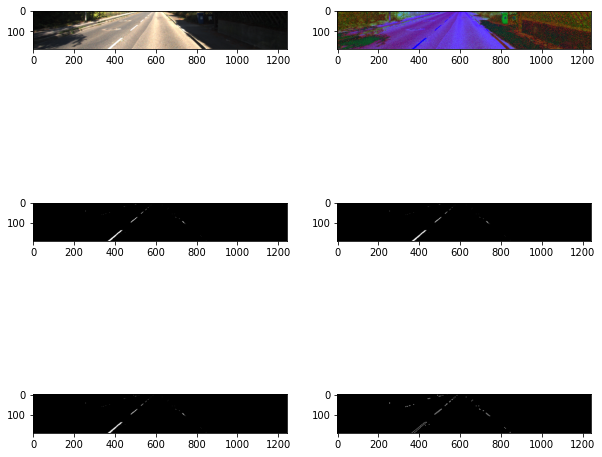

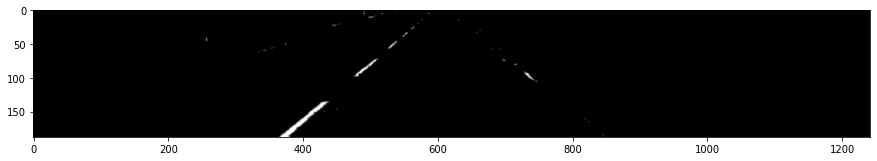

In [63]:
f, axarr = plt.subplots(3, 2, figsize=(10, 10))
axarr[0, 0].imshow(cropped_image)
axarr[0, 1].imshow(hsv_image)
axarr[1, 0].imshow(masked_image, cmap="gray")
axarr[1, 1].imshow(blurred_image, cmap="gray")
axarr[2, 0].imshow(closed_masked_image, cmap="gray")
axarr[2, 1].imshow(canny_image, cmap="gray")
plt.figure(figsize=(15, 15))
plt.imshow(edged_image, cmap="gray")

## Contour processing

Find contours in image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


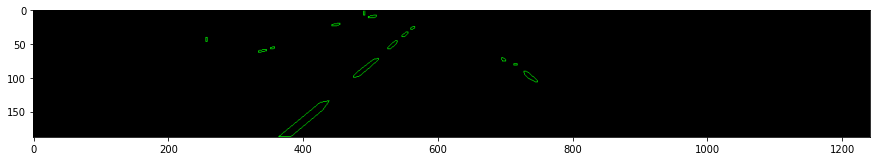

In [64]:
contours, _ = cv2.findContours(edged_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cont_image = np.zeros([edged_image.shape[0], edged_image.shape[1], 3])
approximated_contours = []

for contour in contours:
    if cv2.contourArea(contour) < 10: continue

    epsilon = 0.01 * cv2.arcLength(contour, True)
    approximated_contour = cv2.approxPolyDP(contour, epsilon, True)
    convex_contour = cv2.convexHull(approximated_contour)
    approximated_contours.append(convex_contour)
    cv2.drawContours(cont_image, [convex_contour], -1, (0, 255, 0), 1)

plt.figure(figsize=(15, 15))
plt.imshow(cont_image)

## Lane Detection

Applies lane detection algorithm 

/tmp/ipykernel_187642/965183646.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = km.fit_predict(points[:, 1:2]).astype(np.int)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


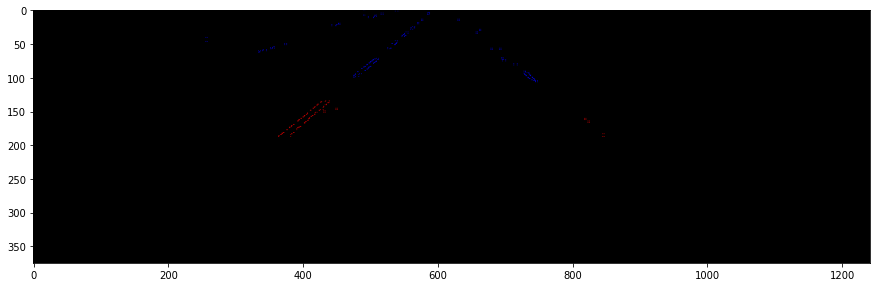

In [75]:
new_image = np.zeros(cont_image.shape)
center_x_coord = int(cont_image.shape[0]/2)
center_y_coord = int(cont_image.shape[1]/2)

#Compile all points in a single vector.
points = []
for contour in contours:
    for vector in contour:
        for point in vector:
            point_copy = point
            point_copy = np.append(point_copy, abs(point[0] - center_x_coord))
            point_copy = np.append(point_copy, np.arctan2(point[1], abs(point[0] - center_x_coord))*180/np.pi)
            points.append(point_copy)
points = np.array(points)

km = KMeans(n_clusters = 2, init='k-means++', n_init=200, max_iter=400, tol=1e-04)
y = km.fit_predict(points[:, 1:2]).astype(np.int)

road1 = points[y==0]
road2 = points[y==1]

for point in road1:
    cv2.circle(new_image, (int(point[0]), int(point[1])), radius=0, color=(0, 0, 255), thickness=-1)

for point in road2:
    cv2.circle(new_image, (int(point[0]), int(point[1])), radius=0, color=(255, 0, 0), thickness=-1)

road1_average = np.average(road1[:, 0])
road2_average = np.average(road2[:, 0])
center_road = 0
if abs(road1_average - center_x_coord) < abs(road2_average - center_x_coord):
    center_road = road1
else:
    center_road = road2
    
plt.figure(figsize=(15, 15))
plt.imshow(new_image)

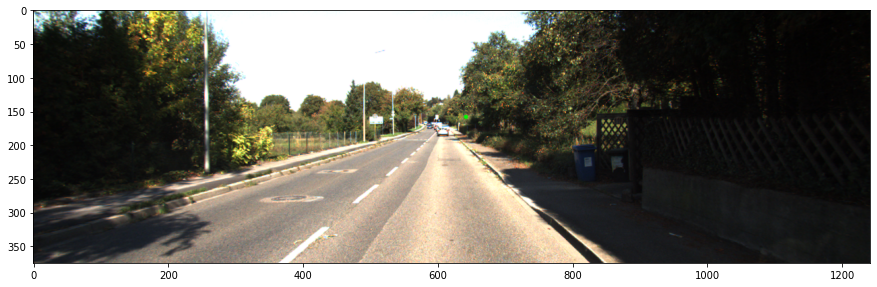

In [80]:
lanes_image = np.array(new_image)
center_x_coord = int(new_image.shape[0]/2)
center_y_coord = int(new_image.shape[1]/2)

max_negative_x = -np.inf
max_negative_y = 0
max_positive_x = np.inf
max_positive_y = 0
for point in center_road:
    if (point[0] - center_x_coord) > max_negative_x:
        max_negative_x = point[0]
        max_negative_y = point[1]
    if (point[0] - center_x_coord) < max_positive_x:
        max_positive_x = point[0]
        max_positive_y = point[1]

x = (max_negative_x + max_positive_x)/2
y = (max_negative_y + max_positive_y)/2

cv2.circle(lanes_image, (int(x), int(y)), radius=0, color=(0, 255, 0), thickness=5)

plt.figure(figsize=(15, 15))
plt.imshow(lanes_image)